### Contexte

In [67]:
import pandas as pd
import torch as torch
import numpy as np
import os
from torch import tensor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [40]:
print(torch.cuda.current_device())      
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("CUDA available:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print(torch.cuda.get_device_name(0))   

0
PyTorch version: 2.5.1+cu121
CUDA version: 12.1
CUDA available: True
Using device: cuda
NVIDIA GeForce RTX 3070


In [41]:

df =  pd.read_csv('data/WorldBankGroup_Statement_Of_Loans_and_Guarantees.csv')

C:\Users\hanna\AppData\Local\Temp\ipykernel_30436\3635210295.py:1: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  df =  pd.read_csv('data/WorldBankGroup_Statement_Of_Loans_and_Guarantees.csv')


### Data Preproccesing 

On supprime les colonnes:
- `"Currency of Commitment"` vide puisqu'on sait que toutes les valeurs monétaires sont en USD
- `"Country / Economy Code"` puisqu'on a aussi une colonne avec le noms complets des pays
- `"Guarantor Country / Economy Code"` Idem
- `"Project ID"` Les identifiants des projets ne nous intéressent pas

In [42]:
df.drop(columns=["Currency of Commitment"], inplace=True)
df.drop(columns=["Country / Economy Code"], inplace=True)
df.drop(columns=["Guarantor Country / Economy Code"], inplace=True)
df.drop(columns=["Project ID"], inplace=True)

Suppression des lignes pour lesquelles on trouve des NA dans les colonnes suivantes:
- `"Interest Rate"`: Taux de NA: 2.24% (Si on ne connait pas le taux d'interet, il est difficile de faire quoi que ce soit) 

In [ ]:
df.dropna(subset=["Interest Rate"], inplace=True)

On précise quand on ne connait pas le projet que finance le pret et on définit une catégorie `"Other"`

In [ ]:
# Drop irrelevant columns
cols_to_drop = ["Loan Number", "Project Name"]  # Add more if needed
df = df.drop(columns=cols_to_drop)

----------------------------------------

In [ ]:
df.shape

(1384312, 27)

In [44]:
df.sample(5)

,End of Period,Loan Number,Region,Country / Economy,Borrower,Guarantor,Loan Type,Loan Status,Interest Rate,Project Name,...,Repaid 3rd Party (US$),Due 3rd Party (US$),Loans Held (US$),First Repayment Date,Last Repayment Date,Agreement Signing Date,Board Approval Date,Effective Date (Most Recent),Closed Date (Most Recent),Last Disbursement Date
1128398,07/31/2018,IBRD02860,SOUTH ASIA,Pakistan,MINISTRY OF FINANCE AND ECONOMIC AFFAIRS,Pakistan,NON POOL,Fully Repaid,0.00,NaN,...,0.0,0,0.0,04/01/1964,10/01/1974,06/27/1961,06/13/1961,12/19/1961,06/30/1967,NaN
505978,12/31/2011,IBRD73000,LATIN AMERICA AND CARIBBEAN,El Salvador,Ministerio de Hacienda,El Salvador,FSL,Terminated,0.00,SV Environmental Services Project,...,0.0,0,0.0,04/07/1970,02/15/2020,NaN,06/02/2005,06/02/2005,07/15/2012,NaN
1141564,03/31/2017,IBRD06650,EUROPE AND CENTRAL ASIA,Greece,NATIONAL INVESTMENT BANK FOR,NaN,NON POOL,Fully Repaid,7.00,NIBID II (DFC),...,0.0,0,0.0,02/01/1972,08/01/1986,04/15/1970,04/07/1970,07/16/1970,12/31/1973,NaN
484091,05/31/2023,IBRD45430,LATIN AMERICA AND CARIBBEAN,Brazil,Ministério da Fazenda,Brazil,SCL,Fully Repaid,6.89,BR ADMIN & FISC REF,...,0.0,0,0.0,07/15/2003,01/15/2005,06/30/2000,03/30/2000,06/30/2000,12/31/2000,06/30/2000
1202281,09/30/2018,IBRD21860,SOUTH ASIA,India,CONTROLLER OF AID ACCOUNTS & AUDIT,India,POOL LOAN,Fully Repaid,11.60,NaN,...,0.0,0,0.0,03/01/1988,09/01/2002,07/06/1982,06/24/1982,09/21/1982,03/31/1989,10/17/1989


In [ ]:
df.columns

Index(['End of Period', 'Region', 'Country / Economy', 'Borrower', 'Guarantor',
       'Loan Type', 'Loan Status', 'Interest Rate',
       'Original Principal Amount (US$)', 'Cancelled Amount (US$)',
       'Undisbursed Amount (US$)', 'Disbursed Amount (US$)',
       'Repaid to IBRD (US$)', 'Due to IBRD (US$)',
       'Exchange Adjustment (US$)', 'Borrower's Obligation (US$)',
       'Sold 3rd Party (US$)', 'Repaid 3rd Party (US$)', 'Due 3rd Party (US$)',
       'Loans Held (US$)', 'First Repayment Date', 'Last Repayment Date',
       'Agreement Signing Date', 'Board Approval Date',
       'Effective Date (Most Recent)', 'Closed Date (Most Recent)',
       'Last Disbursement Date'],
      dtype='object')

In [ ]:
df.describe()

,Interest Rate,Original Principal Amount (US$),Cancelled Amount (US$),Undisbursed Amount (US$),Disbursed Amount (US$),Repaid to IBRD (US$),Due to IBRD (US$),Exchange Adjustment (US$),Borrower's Obligation (US$),Sold 3rd Party (US$),Repaid 3rd Party (US$),Due 3rd Party (US$),Loans Held (US$)
count,1.384312e+06,1.384312e+06,1.384312e+06,1.384312e+06,1.384312e+06,1.384312e+06,1.384312e+06,1.384312e+06,1.384312e+06,1.384312e+06,1.384312e+06,1384312.0,1.384312e+06
mean,4.386095e+00,8.439240e+07,1.002202e+07,7.755784e+06,6.649233e+07,4.344572e+07,2.269393e+07,-4.226992e+05,2.227123e+07,4.487509e+05,4.487509e+05,0.0,3.044971e+07
std,3.379310e+00,1.557073e+08,4.586497e+07,5.014120e+07,1.373416e+08,9.290284e+07,1.004272e+08,1.165660e+07,9.675374e+07,3.887006e+06,3.887006e+06,0.0,1.166025e+08
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.200000e-01,0.000000e+00,0.000000e+00,-1.483090e+08,-1.100785e+09,-2.600000e-01,0.000000e+00,0.000000e+00,0.0,-1.483090e+08
25%,0.000000e+00,1.207847e+07,0.000000e+00,0.000000e+00,6.985481e+06,3.119376e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00
50%,5.300000e+00,3.325320e+07,3.212700e+02,0.000000e+00,2.392313e+07,1.549080e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00
75%,7.250000e+00,9.890131e+07,3.726809e+06,0.000000e+00,7.000000e+07,4.600000e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00
max,2.825000e+01,3.750000e+09,1.995000e+09,3.379011e+09,3.153531e+09,3.000000e+09,2.923282e+09,5.065767e+08,2.842924e+09,2.499620e+08,2.499620e+08,0.0,3.750000e+09


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1384312 entries, 0 to 1416098
Data columns (total 27 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   End of Period                    1384312 non-null  object 
 1   Region                           1384312 non-null  object 
 2   Country / Economy                1384312 non-null  object 
 3   Borrower                         1374686 non-null  object 
 4   Guarantor                        1314652 non-null  object 
 5   Loan Type                        1384312 non-null  object 
 6   Loan Status                      1384312 non-null  object 
 7   Interest Rate                    1384312 non-null  float64
 8   Original Principal Amount (US$)  1384312 non-null  float64
 9   Cancelled Amount (US$)           1384312 non-null  float64
 10  Undisbursed Amount (US$)         1384312 non-null  float64
 11  Disbursed Amount (US$)           1384312 non-null  floa

In [ ]:
(1416099 - 1384312) / 1416099

0.022446876948574924

In [ ]:
df.columns[df.isna().any()]

Index(['Borrower', 'Guarantor', 'First Repayment Date', 'Last Repayment Date',
       'Agreement Signing Date', 'Board Approval Date',
       'Effective Date (Most Recent)', 'Closed Date (Most Recent)',
       'Last Disbursement Date'],
      dtype='object')

In [ ]:
df.groupby('Loan Status').count()

,End of Period,Region,Country / Economy,Borrower,Guarantor,Loan Type,Interest Rate,Original Principal Amount (US$),Cancelled Amount (US$),Undisbursed Amount (US$),...,Repaid 3rd Party (US$),Due 3rd Party (US$),Loans Held (US$),First Repayment Date,Last Repayment Date,Agreement Signing Date,Board Approval Date,Effective Date (Most Recent),Closed Date (Most Recent),Last Disbursement Date
Loan Status,,,,,,,,,,,,,,,,,,,,,
Approved,7314,7314,7314,7314,7252,7314,7314,7314,7314,7314,...,7314,7314,7314,7191,7191,18,7314,463,7314,0
Cancelled,12075,12075,12075,11877,10035,12075,12075,12075,12075,12075,...,12075,12075,12075,12075,12075,10800,12075,12075,11698,741
Disbursed,78540,78540,78540,78540,74610,78540,78540,78540,78540,78540,...,78540,78540,78540,78540,78540,78540,78540,78540,78540,74373
Disbursing,84491,84491,84491,84491,82696,84491,84491,84491,84491,84491,...,84491,84491,84491,84491,84491,84491,84491,84491,84491,84477
Disbursing&Repaying,14328,14328,14328,14328,14328,14328,14328,14328,14328,14328,...,14328,14328,14328,14328,14328,14328,14328,14328,14328,14325
Draft,1,1,1,0,0,1,1,1,1,1,...,1,1,1,0,0,0,0,0,1,0
Effective,3637,3637,3637,3637,3492,3637,3637,3637,3637,3637,...,3637,3637,3637,3327,3327,3637,3637,3637,3637,42
Fully Cancelled,17257,17257,17257,16948,14905,17257,17257,17257,17257,17257,...,17257,17257,17257,17257,17257,15321,17257,17164,17257,1236
Fully Disbursed,27321,27321,27321,27321,27321,27321,27321,27321,27321,27321,...,27321,27321,27321,27321,27321,27321,27321,27321,27321,27321


In [ ]:
df['Loan Status'].unique()

array(['Fully Repaid', 'Repaid', 'Cancelled', 'Fully Cancelled',
       'Disbursed', 'Repaying', 'Fully Transferred', 'Disbursing',
       'Terminated', 'Disbursing&Repaying', 'Fully Disbursed', 'Signed',
       'Approved', 'Effective', 'Draft'], dtype=object)

In [38]:
nombre_classe = df['Loan Status'].value_counts().count()
print("Nombre de classes : ", nombre_classe)

Nombre de classes :  16


In [ ]:
date_cols = [col for col in df.columns if 'Date' in col or 'Period' in col]
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce').dt.year.fillna(0)

#### Data Split en train et validation 

In [ ]:
target_col = "Loan Status"

In [ ]:
# Encode categorical columns
categorical_cols = df.select_dtypes(include='object').columns.drop(target_col)
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

In [ ]:
# Encode target separately
target_le = LabelEncoder()
df[target_col] = target_le.fit_transform(df[target_col])

In [ ]:
# Normalize numerical columns
scaler = StandardScaler()
numeric_cols = df.select_dtypes(include=np.number).columns.drop(target_col)
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [ ]:
# Features and labels
X = df[numeric_cols.union(categorical_cols)]
y = df[target_col]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

### Algo 1) reseaux de neurone

In [ ]:

class LoanStatusClassifier(nn.Module):
    def __init__(self, input_size, hidden_sizes=[128, 64], num_classes=10):
        super(LoanStatusClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.output = nn.Linear(hidden_sizes[1], num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.output(x)

#### Definir l'optimiseur et entrrainer les epochs

In [ ]:
num_classes = len(np.unique(y_train))
model = LoanStatusClassifier(input_size=X_train.shape[1], num_classes=nombre_classe)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    train_losses = []
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        train_losses.append(total_loss)


    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}")


Epoch [1/50], Loss: 3733.3417
Epoch [2/50], Loss: 2490.2221
Epoch [3/50], Loss: 2124.3695
Epoch [4/50], Loss: 1915.8238
Epoch [5/50], Loss: 1807.9868
Epoch [6/50], Loss: 1712.1698
Epoch [7/50], Loss: 1657.6197
Epoch [8/50], Loss: 1607.2576
Epoch [9/50], Loss: 1567.4411
Epoch [10/50], Loss: 1523.3324
Epoch [11/50], Loss: 1488.4734
Epoch [12/50], Loss: 1458.9100
Epoch [13/50], Loss: 1439.4088
Epoch [14/50], Loss: 1424.9399
Epoch [15/50], Loss: 1405.0852
Epoch [16/50], Loss: 1390.6677
Epoch [17/50], Loss: 1368.5773
Epoch [18/50], Loss: 1360.8804
Epoch [19/50], Loss: 1347.8078
Epoch [20/50], Loss: 1330.7169
Epoch [21/50], Loss: 1325.4370
Epoch [22/50], Loss: 1308.2694
Epoch [23/50], Loss: 1308.3369
Epoch [24/50], Loss: 1292.1046
Epoch [25/50], Loss: 1286.1024
Epoch [26/50], Loss: 1280.8774
Epoch [27/50], Loss: 1267.9050
Epoch [28/50], Loss: 1265.8533
Epoch [29/50], Loss: 1258.8227
Epoch [30/50], Loss: 1256.7027
Epoch [31/50], Loss: 1246.1741
Epoch [32/50], Loss: 1244.3830
Epoch [33/50], Lo

#### Evaluer le model 

In [30]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 97.23%


#### Tracer la courbe de losss

In [ ]:


plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()


### Algo 2) XGBoost

In [69]:
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

# Accuracy
print(f"✅ XGBoost Accuracy: {accuracy_score(y_test, xgb_pred):.4f}")

# Classification report avec classes présentes
labels_present = unique_labels(y_test, xgb_pred)
target_names_filtered = target_le.inverse_transform(labels_present)

print("\n📊 Classification Report (XGBoost):\n")
print(classification_report(y_test, xgb_pred, labels=labels_present, target_names=target_names_filtered))


c:\Users\hanna\OneDrive\Documents\POLY\Projet_IND\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:52:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ XGBoost Accuracy: 0.9760

📊 Classification Report (XGBoost):

                     precision    recall  f1-score   support

           Approved       1.00      0.99      1.00      1492
          Cancelled       0.95      1.00      0.97      2346
          Disbursed       0.94      0.96      0.95     15751
         Disbursing       0.98      0.98      0.98     16828
Disbursing&Repaying       0.99      0.91      0.95      2874
          Effective       0.85      0.80      0.83       729
    Fully Cancelled       1.00      0.97      0.98      3428
    Fully Disbursed       0.97      0.92      0.95      5445
       Fully Repaid       1.00      0.97      0.98    126874
  Fully Transferred       1.00      1.00      1.00      4354
             Repaid       0.95      1.00      0.97     73500
           Repaying       0.99      0.94      0.97     20799
             Signed       0.86      0.89      0.88       951
         Terminated       1.00      1.00      1.00      1492

           accuracy

### Algo 3) LightGBM

In [70]:
lgbm_model = LGBMClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)

lgbm_model.fit(X_train, y_train)
lgbm_pred = lgbm_model.predict(X_test)

# Accuracy
print(f"✅ LightGBM Accuracy: {accuracy_score(y_test, lgbm_pred):.4f}")

# Classification report avec classes présentes
labels_present = unique_labels(y_test, lgbm_pred)
target_names_filtered = target_le.inverse_transform(labels_present)

print("\n📊 Classification Report (LightGBM):\n")
print(classification_report(y_test, lgbm_pred, labels=labels_present, target_names=target_names_filtered))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4215
[LightGBM] [Info] Number of data points in the train set: 1107449, number of used features: 25
[LightGBM] [Info] Start training from score -5.248171
[LightGBM] [Info] Start training from score -4.734703
[LightGBM] [Info] Start training from score -2.870035
[LightGBM] [Info] Start training from score -2.795275
[LightGBM] [Info] Start training from score -4.571475
[LightGBM] [Info] Start training from score -13.917570
[LightGBM] [Info] Start training from score -5.942349
[LightGBM] [Info] Start training from score -4.383047
[LightGBM] [Info] Start training from score -3.924424
[LightGBM] [Info] Start training from score -0.780353
[LightGBM] [Info] Start training from score -4.160496
[LightGBM] [Info] Start training f

c:\Users\hanna\OneDrive\Documents\POLY\Projet_IND\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hanna\OneDrive\Documents\POLY\Projet_IND\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hanna\OneDrive\Documents\POLY\Projet_IND\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

### Algo 4) Regression Logistique Multiclasse

In [45]:
class LogisticRegressionMulti(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegressionMulti, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        return self.linear(x)  # Pas de softmax ici ! CrossEntropyLoss le fait pour nous


In [46]:
model = LogisticRegressionMulti(input_size=X_train.shape[1], num_classes=num_classes).to(device)


In [ ]:

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.adam(model.parameters(), lr=0.01)  


In [48]:
num_epochs = 50
train_losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    train_losses.append(total_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}")


Epoch [1/50], Loss: 10047.3119
Epoch [2/50], Loss: 7378.3899
Epoch [3/50], Loss: 6852.2658
Epoch [4/50], Loss: 6563.1426
Epoch [5/50], Loss: 6368.3477
Epoch [6/50], Loss: 6224.0454
Epoch [7/50], Loss: 6110.7556
Epoch [8/50], Loss: 6017.5037
Epoch [9/50], Loss: 5938.8603
Epoch [10/50], Loss: 5870.8887
Epoch [11/50], Loss: 5811.3211
Epoch [12/50], Loss: 5758.1495
Epoch [13/50], Loss: 5710.1852
Epoch [14/50], Loss: 5666.6903
Epoch [15/50], Loss: 5627.2313
Epoch [16/50], Loss: 5590.6568
Epoch [17/50], Loss: 5556.8448
Epoch [18/50], Loss: 5525.1358
Epoch [19/50], Loss: 5496.0124
Epoch [20/50], Loss: 5468.7188
Epoch [21/50], Loss: 5442.1984
Epoch [22/50], Loss: 5417.6869
Epoch [23/50], Loss: 5394.7935
Epoch [24/50], Loss: 5372.7803
Epoch [25/50], Loss: 5351.9946
Epoch [26/50], Loss: 5332.0237
Epoch [27/50], Loss: 5313.1653
Epoch [28/50], Loss: 5294.9880
Epoch [29/50], Loss: 5277.5622
Epoch [30/50], Loss: 5260.8876
Epoch [31/50], Loss: 5244.7837
Epoch [32/50], Loss: 5229.3077
Epoch [33/50], L

In [49]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 90.02%


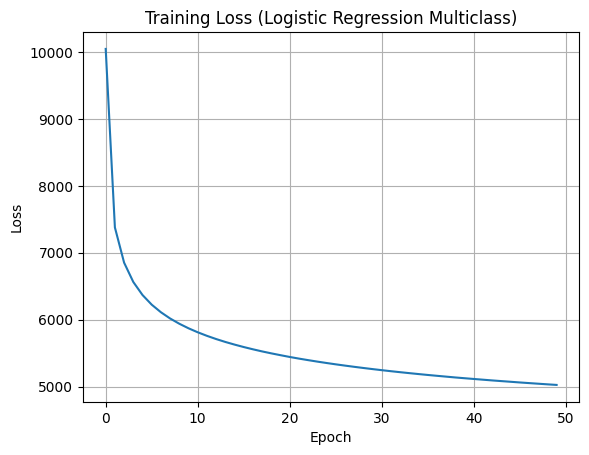

In [50]:
plt.plot(train_losses)
plt.title("Training Loss (Logistic Regression Multiclass)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


### Algo 5) Random forest 

In [52]:
rf_model = RandomForestClassifier(
    n_estimators=100,     # nombre d’arbres
    max_depth=None,       # profondeur des arbres (None = croissance max)
    random_state=42       # reproductibilité
)

rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

#### Évaluer le modèle

In [57]:
y_pred = rf_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

print(rf_model.criterion)  # Affiche 'gini' ou 'entropy'

# Identifie les classes présentes dans y_test
labels_present = unique_labels(y_test, y_pred)

# Génère les noms correspondants à ces classes
target_names_filtered = target_le.inverse_transform(labels_present)

# Classification report correct
print("\nClassification Report:\n", classification_report(
    y_test, y_pred, labels=labels_present, target_names=target_names_filtered))




Accuracy: 0.9815107110737079
gini

Classification Report:
                      precision    recall  f1-score   support

           Approved       1.00      0.99      1.00      1492
          Cancelled       0.96      0.99      0.98      2346
          Disbursed       0.95      0.98      0.97     15751
         Disbursing       0.99      0.99      0.99     16828
Disbursing&Repaying       0.98      0.96      0.97      2874
          Effective       0.87      0.88      0.88       729
    Fully Cancelled       1.00      0.98      0.99      3428
    Fully Disbursed       0.97      0.94      0.96      5445
       Fully Repaid       1.00      0.97      0.99    126874
  Fully Transferred       1.00      1.00      1.00      4354
             Repaid       0.96      1.00      0.98     73500
           Repaying       0.99      0.97      0.98     20799
             Signed       0.91      0.91      0.91       951
         Terminated       1.00      1.00      1.00      1492

           accuracy     

#### Importance des features

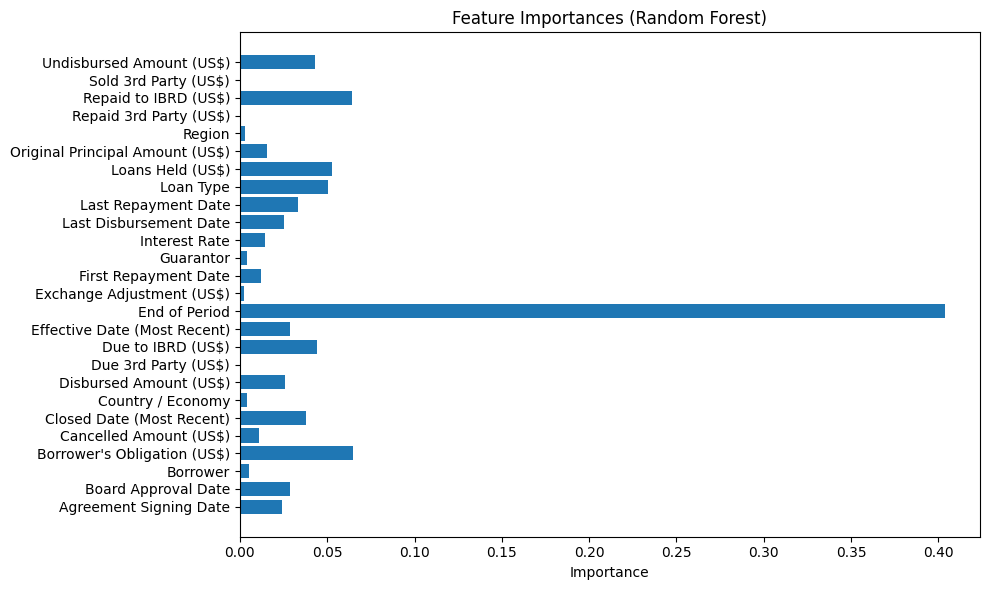

In [54]:


importances = rf_model.feature_importances_
features = X_train.columns

plt.figure(figsize=(10, 6))
plt.barh(features, importances)
plt.title("Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


#### confusion matrix

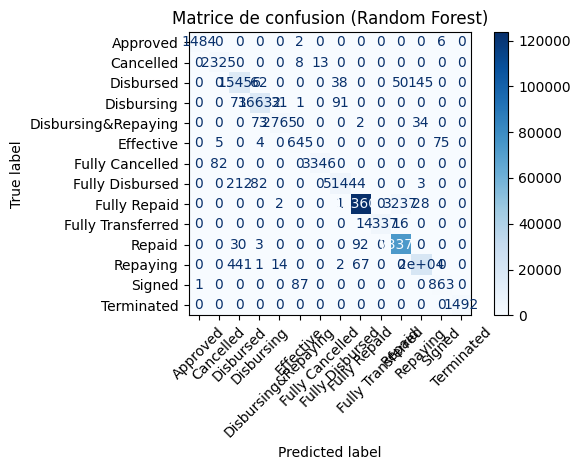

✅ Précision globale (Accuracy): 0.9815


In [62]:

# Trouve les classes réellement présentes dans y_test et y_pred
labels_present = unique_labels(y_test, y_pred)

# Génère la confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=labels_present)

# Affiche les labels correspondants
display_labels = target_le.inverse_transform(labels_present)

# Affichage
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(xticks_rotation=45, cmap="Blues")
plt.title("Matrice de confusion (Random Forest)")
plt.tight_layout()
plt.show()
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Précision globale (Accuracy): {accuracy:.4f}")